In [1]:
import re
import pandas as pd
import numpy as np
from collections import Counter
import urllib.request

import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from konlpy.tag import Okt

In [2]:
data_path = "../data/"
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", 
    filename=data_path + "shopping_ratings_total.txt")

('../data/shopping_ratings_total.txt',
 <http.client.HTTPMessage at 0x2a1591a90>)

In [3]:
df = pd.read_table(data_path + "shopping_ratings_total.txt", names=['ratings', 'reviews']) # set column names
print(len(df))
print(df.head(5))

200000
   ratings                                            reviews
0        5                                            배공빠르고 굿
1        2                      택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2        5  아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3        2  선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4        5                  민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


# Data Preprocessing

In [4]:
# add new columns
df['label'] = df['ratings'].apply(lambda x: 1 if x>3 else 0) # 1: positive, 0: negative
df.head(5)

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [5]:
# remove null and duplicate values
print(df['ratings'].nunique(), df['reviews'].nunique(), df['label'].nunique()) # check unique values
df.drop_duplicates(subset=['reviews'], inplace=True) # drop duplicates
df.dropna(how='any', inplace=True) # drop null values
print(len(df), df.isnull().values.any()) # check null values

4 199908 2
199908 False


In [6]:
# split total into train and test data
train_data, test_data = train_test_split(df, test_size=0.25, random_state=42) # random_state: seed
print(len(train_data), len(test_data), print(len(df)))

199908
149931 49977 None


<Axes: xlabel='label'>

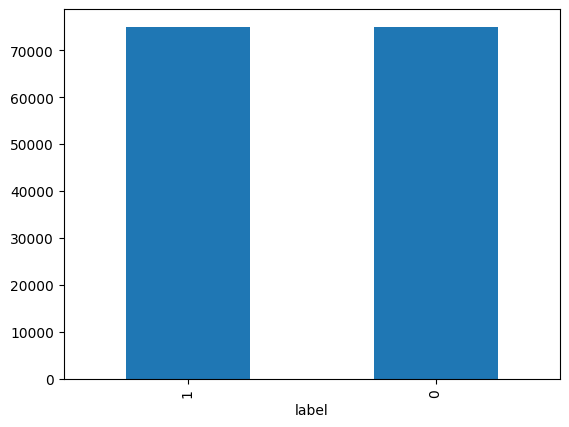

In [7]:
 # check if evenly distributed
train_data['label'].value_counts().plot(kind='bar')

In [8]:
train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "") # convert non-Korean characters to blank
test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "") 

train_data['reviews'].replace("", np.nan, inplace=True) # convert blank to null
test_data['reviews'].replace("", np.nan, inplace=True) 

train_data.dropna(how='any', inplace=True) # drop null values
test_data.dropna(how='any', inplace=True) 

train_data.drop_duplicates(subset=['reviews'], inplace=True) # drop duplicates
test_data.drop_duplicates(subset=['reviews'], inplace=True)

print(train_data['reviews'].nunique(), train_data.isnull().sum()) # check null values and unique values
print(test_data['reviews'].nunique(), test_data.isnull().sum())

149931 ratings    0
reviews    0
label      0
dtype: int64
49977 ratings    0
reviews    0
label      0
dtype: int64


# Tokenizing

In [9]:
okt = Okt()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

print(okt.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔')) # test

['와', '이런', '것', '도', '상품', '이라고', '차라리', '내', '가', '만드는', '게', '나을', '뻔']


In [10]:
train_data['tokenized'] = train_data['reviews'].apply(lambda x: okt.morphs(x, stem=True)) # tokenize train data
train_data['tokenized'] = train_data['reviews'].apply(lambda x: [word for word in x if not word in stopwords]) # remove stopwords

test_data['tokenized'] = test_data['reviews'].apply(lambda x: okt.morphs(x, stem=True)) # tokenize test data
test_data['tokenized'] = test_data['reviews'].apply(lambda x: [word for word in x if not word in stopwords]) # remove stopwords